# 01 - Data Ingestion and Exploratory Data Analysis

This notebook covers:
- Loading the tourism data
- Initial data exploration
- Statistical analysis
- Visualization of time series patterns

In [13]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

### 1. Load and Examine the Data

First, let's load the processed tourism data and examine its structure.

In [14]:
# Load the processed tourism data
df = pd.read_csv('../data/processed/monthly_tourist_arrivals.csv')

# Display basic information about the dataset
print("Dataset shape:", df.shape)
print("\nColumn names:", df.columns.tolist())
print("\nData types:")
print(df.dtypes)
print("\nFirst few rows:")
df.head()

Dataset shape: (100, 2)

Column names: ['Date', 'Arrivals']

Data types:
Date        object
Arrivals     int64
dtype: object

First few rows:


,Date,Arrivals
0,2017-01-01,219360
1,2017-02-01,197517
2,2017-03-01,188076
3,2017-04-01,160249
4,2017-05-01,121891


### 2. Convert Date to Datetime and Set as Index

Convert the Date column to datetime format and set it as the index.

In [15]:
# Convert Date column to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Set Date as index for time series analysis
df.set_index('Date', inplace=True)

# Sort by date to ensure chronological order
df.sort_index(inplace=True)

print("Data after conversion:")
print(f"Index type: {type(df.index)}")
print(f"Index name: {df.index.name}")
print(f"Date range: {df.index.min()} to {df.index.max()}")
print(f"Frequency: {pd.infer_freq(df.index)}")
print(f"\nDataset shape: {df.shape}")
df.head()

Data after conversion:
Index type: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index name: Date
Date range: 2017-01-01 00:00:00 to 2025-08-01 00:00:00
Frequency: None

Dataset shape: (100, 1)


,Arrivals
Date,
2017-01-01,219360
2017-02-01,197517
2017-03-01,188076
2017-04-01,160249
2017-05-01,121891


In [16]:
print("Full date range analysis:")
print(df.tail(10))
print("\nData from 2024 onwards:")
df_2024_onwards = df[df.index >= '2024-01-01']
print(df_2024_onwards)

Full date range analysis:
            Arrivals
Date                
2024-07-01    187810
2024-08-01    164609
2025-01-01    252761
2025-02-01    240217
2025-03-01    229298
2025-04-01    174608
2025-05-01    132919
2025-06-01    138241
2025-07-01    200244
2025-08-01    198235

Data from 2024 onwards:
            Arrivals
Date                
2024-01-01    208253
2024-02-01    218350
2024-03-01    209181
2024-04-01    148867
2024-05-01    112128
2024-06-01    113470
2024-07-01    187810
2024-08-01    164609
2025-01-01    252761
2025-02-01    240217
2025-03-01    229298
2025-04-01    174608
2025-05-01    132919
2025-06-01    138241
2025-07-01    200244
2025-08-01    198235


### 3. Filter up to July 2024

In [17]:
# Filter data to include only actual data up to July 2024
# This excludes the August 2024 and 2025 data which may be incomplete or projected
df_filtered = df[df.index <= '2024-07-01'].copy()

print(f"Original dataset: {df.shape[0]} records")
print(f"Filtered dataset: {df_filtered.shape[0]} records")
print(f"Date range after filtering: {df_filtered.index.min()} to {df_filtered.index.max()}")
print(f"Records removed: {df.shape[0] - df_filtered.shape[0]}")

# Check the frequency of the filtered data
freq = pd.infer_freq(df_filtered.index)
print(f"Inferred frequency: {freq}")

# Display the last few records to confirm filtering
print(f"\nLast 5 records in filtered dataset:")
print(df_filtered.tail())

Original dataset: 100 records
Filtered dataset: 91 records
Date range after filtering: 2017-01-01 00:00:00 to 2024-07-01 00:00:00
Records removed: 9
Inferred frequency: MS

Last 5 records in filtered dataset:
            Arrivals
Date                
2024-03-01    209181
2024-04-01    148867
2024-05-01    112128
2024-06-01    113470
2024-07-01    187810


### 4. Save Filtered Dataset

Save the clean, filtered dataset for use in subsequent analysis and modeling.

In [18]:
# Save the filtered dataset
output_path = '../data/processed/monthly_tourist_arrivals_filtered.csv'
df_filtered.to_csv(output_path)

print(f"Filtered dataset saved to: {output_path}")
print(f"Dataset contains {df_filtered.shape[0]} monthly records")
print(f"Date range: {df_filtered.index.min().strftime('%Y-%m')} to {df_filtered.index.max().strftime('%Y-%m')}")

# Verify the saved file
df_verify = pd.read_csv(output_path, index_col='Date', parse_dates=True)
print(f"\nVerification - loaded dataset shape: {df_verify.shape}")
print("Successfully saved and verified the filtered dataset!")

Filtered dataset saved to: ../data/processed/monthly_tourist_arrivals_filtered.csv
Dataset contains 91 monthly records
Date range: 2017-01 to 2024-07

Verification - loaded dataset shape: (91, 1)
Successfully saved and verified the filtered dataset!


### 5. Data Summary

Create a summary of our prepared dataset for the next phases of analysis.

In [19]:
# Final summary statistics
print("=== DATASET SUMMARY ===")
print(f"📊 Records: {df_filtered.shape[0]} monthly observations")
print(f"📅 Time Range: {df_filtered.index.min().strftime('%B %Y')} to {df_filtered.index.max().strftime('%B %Y')}")
print(f"⏱️  Duration: {(df_filtered.index.max() - df_filtered.index.min()).days / 365.25:.1f} years")
print(f"🔄 Frequency: Monthly (MS)")
print(f"📈 Variable: Tourist Arrivals")

print(f"\n=== STATISTICAL SUMMARY ===")
print(df_filtered['Arrivals'].describe())

print(f"\n=== MAJOR EVENTS IMPACT ANALYSIS ===")

# COVID-19 Analysis
pre_covid = df_filtered.loc['2017':'2019']['Arrivals'].mean()
covid_2020 = df_filtered.loc['2020']['Arrivals'].mean()
covid_2021 = df_filtered.loc['2021']['Arrivals'].mean()
recovery_2022_2024 = df_filtered.loc['2022':'2024']['Arrivals'].mean()

print(f"📍 COVID-19 Impact (2020-2021):")
print(f"  Pre-COVID average (2017-2019): {pre_covid:,.0f} arrivals/month")
print(f"  COVID 2020 average: {covid_2020:,.0f} arrivals/month ({(covid_2020/pre_covid-1)*100:+.1f}%)")
print(f"  COVID 2021 average: {covid_2021:,.0f} arrivals/month ({(covid_2021/pre_covid-1)*100:+.1f}%)")
print(f"  Recovery period (2022-2024): {recovery_2022_2024:,.0f} arrivals/month ({(recovery_2022_2024/pre_covid-1)*100:+.1f}%)")

# Easter Sunday Bombing Attack Analysis (April 2019)
pre_attack_2019_q1 = df_filtered.loc['2019-01':'2019-03']['Arrivals'].mean()
post_attack_2019_q2q3 = df_filtered.loc['2019-05':'2019-09']['Arrivals'].mean()  # May-Sep impact period
recovery_2019_q4 = df_filtered.loc['2019-11':'2019-12']['Arrivals'].mean()

print(f"\n💥 Easter Sunday Bombing Attack (April 21, 2019):")
print(f"  Pre-attack Q1 2019: {pre_attack_2019_q1:,.0f} arrivals/month")
print(f"  Impact period (May-Sep 2019): {post_attack_2019_q2q3:,.0f} arrivals/month ({(post_attack_2019_q2q3/pre_attack_2019_q1-1)*100:+.1f}%)")
print(f"  Recovery Q4 2019: {recovery_2019_q4:,.0f} arrivals/month ({(recovery_2019_q4/pre_attack_2019_q1-1)*100:+.1f}%)")

# Economic Crisis Analysis (2022)
pre_crisis_2022_q1 = df_filtered.loc['2022-01':'2022-03']['Arrivals'].mean()
crisis_2022_q2q3 = df_filtered.loc['2022-04':'2022-09']['Arrivals'].mean()  # April-Sep crisis period
post_crisis_2022_q4 = df_filtered.loc['2022-10':'2022-12']['Arrivals'].mean()

print(f"\n📉 Economic Crisis (March-July 2022):")
print(f"  Pre-crisis Q1 2022: {pre_crisis_2022_q1:,.0f} arrivals/month")
print(f"  Crisis period (Apr-Sep 2022): {crisis_2022_q2q3:,.0f} arrivals/month ({(crisis_2022_q2q3/pre_crisis_2022_q1-1)*100:+.1f}%)")
print(f"  Post-crisis Q4 2022: {post_crisis_2022_q4:,.0f} arrivals/month ({(post_crisis_2022_q4/pre_crisis_2022_q1-1)*100:+.1f}%)")

print(f"\n✅ Data is ready for time series forecasting analysis!")

=== DATASET SUMMARY ===
📊 Records: 91 monthly observations
📅 Time Range: January 2017 to July 2024
⏱️  Duration: 7.5 years
🔄 Frequency: Monthly (MS)
📈 Variable: Tourist Arrivals

=== STATISTICAL SUMMARY ===
count        91.000000
mean     115070.813187
std       81696.225334
min           0.000000
25%       37781.000000
50%      113470.000000
75%      187943.000000
max      253169.000000
Name: Arrivals, dtype: float64

=== MAJOR EVENTS IMPACT ANALYSIS ===
📍 COVID-19 Impact (2020-2021):
  Pre-COVID average (2017-2019): 176,775 arrivals/month
  COVID 2020 average: 42,309 arrivals/month (-76.1%)
  COVID 2021 average: 16,208 arrivals/month (-90.8%)
  Recovery period (2022-2024): 109,850 arrivals/month (-37.9%)

💥 Easter Sunday Bombing Attack (April 21, 2019):
  Pre-attack Q1 2019: 246,867 arrivals/month
  Impact period (May-Sep 2019): 93,747 arrivals/month (-62.0%)
  Recovery Q4 2019: 209,324 arrivals/month (-15.2%)

📉 Economic Crisis (March-July 2022):
  Pre-crisis Q1 2022: 95,111 arrival

## 6. Quick Visualization

Create a simple time series plot to visualize the data and confirm our observations about COVID-19 impact.

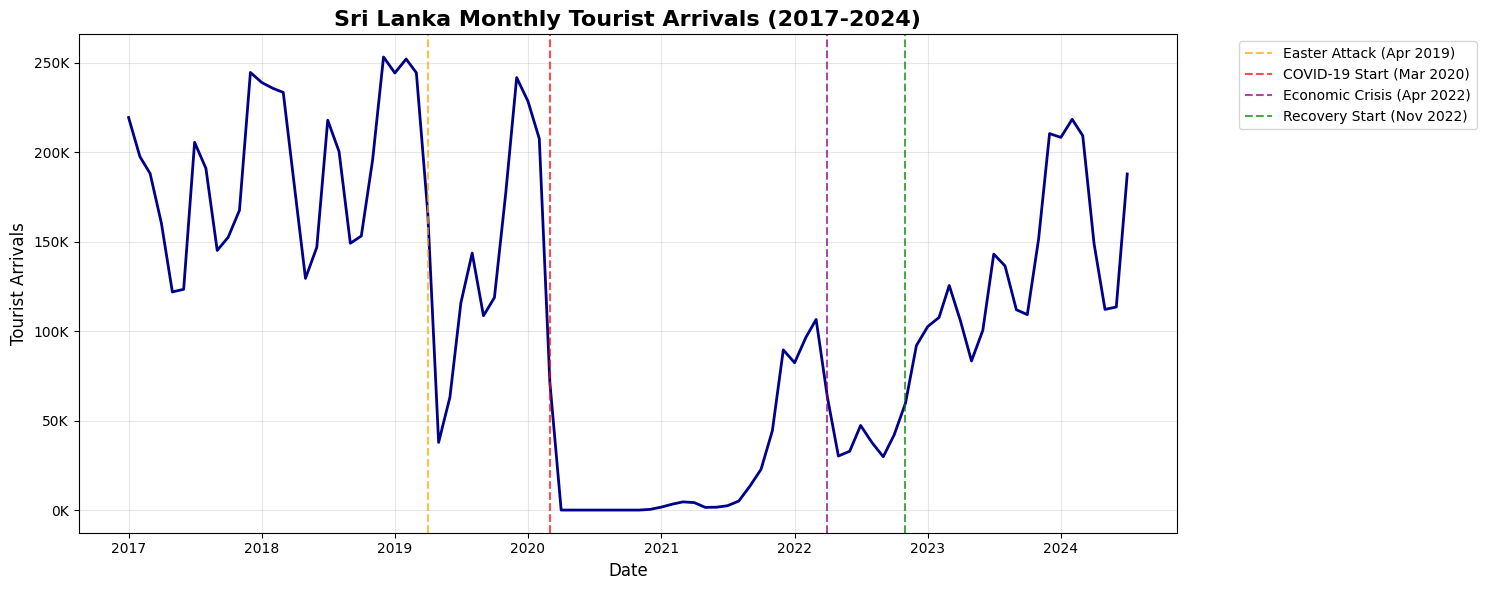

📈 Time series visualization shows major events impact:
   🔸 Easter Sunday Attack: Sharp but short-lived impact (Apr-Oct 2019)
   🔸 COVID-19: Prolonged and severe impact (Mar 2020-2021)
   🔸 Economic Crisis: Political instability and shortages (Apr-Oct 2022)
📁 Filtered dataset saved as: monthly_tourist_arrivals_filtered.csv


In [20]:
# Create a time series plot
plt.figure(figsize=(15, 6))
plt.plot(df_filtered.index, df_filtered['Arrivals'], linewidth=2, color='darkblue')
plt.title('Sri Lanka Monthly Tourist Arrivals (2017-2024)', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Tourist Arrivals', fontsize=12)
plt.grid(True, alpha=0.3)

# Add vertical lines to mark key events
plt.axvline(pd.to_datetime('2019-04'), color='orange', linestyle='--', alpha=0.7, label='Easter Attack (Apr 2019)')
plt.axvline(pd.to_datetime('2020-03'), color='red', linestyle='--', alpha=0.7, label='COVID-19 Start (Mar 2020)')
plt.axvline(pd.to_datetime('2022-04'), color='purple', linestyle='--', alpha=0.7, label='Economic Crisis (Apr 2022)')
plt.axvline(pd.to_datetime('2022-11'), color='green', linestyle='--', alpha=0.7, label='Recovery Start (Nov 2022)')

# Format y-axis to show numbers in thousands
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1000:.0f}K'))

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

print("📈 Time series visualization shows major events impact:")
print("   🔸 Easter Sunday Attack: Sharp but short-lived impact (Apr-Oct 2019)")
print("   🔸 COVID-19: Prolonged and severe impact (Mar 2020-2021)")  
print("   🔸 Economic Crisis: Political instability and shortages (Apr-Oct 2022)")
print("📁 Filtered dataset saved as: monthly_tourist_arrivals_filtered.csv")